In [1]:
import pandas as pd
import numpy as np
import sklearn as sklearn 
import datetime
import matplotlib.pyplot as plt
from dateutil.relativedelta import *
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
import math 
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, mutual_info_regression
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

## 1. Restructure data for supervised learning

In [2]:
# import data-set
df = pd.read_csv('carbon_subset_Weekly_df.csv')
df.reset_index(inplace = True)
del df['index']
del df['level_0']
del df['Benchmark']
del df['Front_Weekly_min'] 
del df['Front_Weekly_max']

del df['CA_Mean']
del df['CA_Median']
del df['CA_Percent Above Floor']
del df['CA_Median allowance price']
del df['AA_Maximum']
del df['CA_Clearing Price']
del df['AA_Mean']
del df['AA_Median']
del df['CA_Maximum']
del df['CA_Cleared Above Floor']
del df['AA_Median allowance price']
del df['AA_Floor Price']
del df['AA_Clearing Price']
del df['CA_Vintage']
del df['AA_Percent above Floor']
del df['AA_Cleared Above Floor']
del df['CA_Minimum']
del df['CA_Floor Price']
del df['AA_Vintage']


# define target (Y) and feature column (X) names
# Y
target_col = ['Front', 'date']

# X
feature_cols = list(df.columns)
feature_cols.remove(target_col[0])
feature_cols.remove(target_col[1])

df_target = df[target_col]
df_features = df[feature_cols]

# datetime encoding
date_name = 'date'
df_target[date_name] = pd.to_datetime(df_target[date_name])
df_target[date_name] = df_target[date_name].dt.strftime('%Y-%m-%d').astype(str)


In [3]:
# create columns of lag observations
df_target['Target_Price+4'] = df_target['Front'].shift(-4)
df_target['Target_Price+12'] = df_target['Front'].shift(-12)
df_target['Target_Price+52'] = df_target['Front'].shift(-52)
df_target['Date+4'] = df_target['date'].shift(-4)
df_target['Date+12'] = df_target['date'].shift(-12)
df_target['Date+52'] = df_target['date'].shift(-52)


## 2. Prepare data for prediction horizons: 1, 3, 12 months into the future 

In [4]:
def get_time_lag(time_lag_in_weeks, date):
    d = datetime.datetime.strptime(date, '%Y-%m-%d')
    d2 = d + relativedelta(days=7*time_lag_in_weeks)
    #print(str(d2)[0:10])
    return str(d2)[0:10]


In [5]:
# forward fill new date columns
def ffill_dates(datename, startdate, time_lag): 
    df_target[datename] = pd.to_datetime(df_target[datename])
    enddate = get_time_lag(time_lag, '2023-04-01')
    fill_vals = pd.date_range(start='2023-04-02', end=enddate, freq='W-TUE').strftime('%Y-%m-%d').tolist()
    df_target[datename][df_target.shape[0]-time_lag:] = fill_vals
    df_target[datename] = df_target[datename].dt.strftime('%Y-%m-%d').astype(str)
    return df_target


df_target = ffill_dates('Date+4', df_target['Date+4'][0], 4)
df_target = ffill_dates('Date+12', df_target['Date+12'][0], 12)
df_target = ffill_dates('Date+52', df_target['Date+52'][0], 52)


# features and target df
df = pd.concat([df_target, df_features], axis=1)

## 3. Feature Engineering

In [6]:
#Date time features

df['date'] = pd.to_datetime(df['date'])
df['quarter'] = df['date'].dt.quarter
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['week'] = df['date'].dt.week
df['weekday'] = df['date'].dt.weekday

AttributeError: 'DatetimeProperties' object has no attribute 'week'

In [ ]:
#Lag features / sliding window features, based on golden feature list

def lag_features(df, col, weeks):
    return df[col].shift(weeks)

# df['Front-1'] = lag_features(df, 'Front', -1)
# df['Front-3'] = lag_features(df, 'Front', -3)
# df['Front-6'] = lag_features(df, 'Front', -6)
# df['Front_monthly_max-1'] = lag_features(df, 'Front_monthly_max', -1)
# df['Front_monthly_max-3'] = lag_features(df, 'Front_monthly_max', -3)
# df['Front_monthly_max-6'] = lag_features(df, 'Front_monthly_max', -6)
# df['Benchmark-1'] = lag_features(df, 'Benchmark', -1)
# df['Benchmark-3'] = lag_features(df, 'Benchmark', -3)
# df['CA_Median allowance price-1'] = lag_features(df, 'CA_Median allowance price', -1)
# df['CA_Median allowance price-3'] = lag_features(df, 'CA_Median allowance price', -3)
# df['AA_Clearing_Price-1'] = lag_features(df, 'AA_Clearing Price', -1)
# df['AA_Clearing_Price-3'] = lag_features(df, 'AA_Clearing Price', -3)
# df['AA_Clearing_Price-6'] = lag_features(df, 'AA_Clearing Price', -6)
# df['CA_Clearing_Price-1'] = lag_features(df, 'CA_Clearing Price', -1)
# df['CA_Clearing_Price-3'] = lag_features(df, 'CA_Clearing Price', -3)
# df['CA_Clearing_Price-6'] = lag_features(df, 'CA_Clearing Price', -6)
# df['AA_Median-3'] = lag_features(df, 'AA_Median', -3)
# df['CA_Median-3'] = lag_features(df, 'CA_Median', -3)


In [ ]:
#plot_acf(df['Front Price '], lags=6)
#plot_pacf(df['Front Price '], lags=6)

In [ ]:
#Rolling window statistics

# moving average
# df['Front_rolling_mean'] = df['Front'].rolling(window=3).mean()
# df['Benchmark_rolling_mean'] = df['Benchmark'].rolling(window=3).mean()

# #Expanding window statistics (consist of features that include all previous data) 
# df['Front_expanding_mean'] = df['Front'].expanding(2).mean()
# df['Front_expanding_min'] = df['Front'].expanding(2).min()
# df['Front_expanding_max'] = df['Front'].expanding(2).max()
# df['Benchmark_expanding_mean'] = df['Benchmark'].expanding(2).mean()
# df['Benchmark_expanding_min'] = df['Benchmark'].expanding(2).min()
# df['Benchmark_expanding_max'] = df['Benchmark'].expanding(2).max()

In [ ]:
#Seasonality features
# seasonal decomposition

df_datetime_idx = df_target[['date', 'Front']].set_index('date')

# Create additive seasonal decomposition
result_add_4 = seasonal_decompose(df_datetime_idx['Front'], model='additive', period=4)
result_add_12 = seasonal_decompose(df_datetime_idx['Front'], model='additive', period=12)

# Plot
print('Monthly decomposition')
fig = result_add_4.plot()
plt.show()

print('\n')
print('Quarterly decomposition')
fig = result_add_12.plot()
plt.show()

In [7]:
def add_decompose_features(df, col, series):
    df[col] = series.values
    return df[col].fillna(method='bfill').fillna(method='ffill')


df_features['trend_4'] = add_decompose_features(df_features, 'trend_4', result_add_4.trend)
df_features['seasonal_4'] = add_decompose_features(df_features, 'seasonal_4', result_add_4.seasonal)
df_features['resid_4'] = add_decompose_features(df_features, 'resid_4', result_add_4.resid)
#df_features['observed_3'] = add_decompose_features(df_features, 'observed_3', result_add_3.observed)

df_features['trend_12'] = add_decompose_features(df_features, 'trend_12', result_add_12.trend)
df_features['seasonal_12'] = add_decompose_features(df_features, 'seasonal_12', result_add_12.seasonal)
df_features['resid_12'] = add_decompose_features(df_features, 'resid_12', result_add_12.resid)
#df_features['observed_12'] = add_decompose_features(df_features, 'observed_12', result_add_12.observed)


NameError: name 'result_add_4' is not defined

In [150]:
#Domain-Specific features 

# Auctions
#both current and advanced auctions take place in feb, may, aug, nov
auct_months = [2, 5, 8, 11]
df['auction_idx'] = np.where(df['month'].isin(auct_months), 1, 0)
# in weekly model: 1 week lag between day of auction and results

In [151]:
# eng_feature_cols = ['Front-1', 'Front-3', 'Front-6', 'Benchmark-1', 'Benchmark-3',
#                     'CA_Median allowance price-1', 'CA_Median allowance price-3',
#                     'AA_Clearing_Price-1', 'AA_Clearing_Price-3', 'AA_Clearing_Price-6', 
#                     'CA_Clearing_Price-1', 'CA_Clearing_Price-3', 'CA_Clearing_Price-6',
#                     'AA_Median-3', 'CA_Median-3', 'Front_rolling_mean', 'Benchmark_rolling_mean', 
#                     'Front_expanding_mean', 'Front_expanding_min', 'Front_expanding_max', 
#                     'Benchmark_expanding_mean', 'Benchmark_expanding_min', 'Benchmark_expanding_max',
#                     'Front_monthly_max-1', 'Front_monthly_max-3', 'Front_monthly_max-6']

# #fill engineered cols
# df[eng_feature_cols] = df[eng_feature_cols].fillna(method='bfill')
# df[eng_feature_cols] = df[eng_feature_cols].fillna(method='ffill')

#feature_cols
remove_feature_cols = ([target_col[0], target_col[1], 'date', 'Target_Price+4', 'Target_Price+12','Target_Price+52', 
                        'Date+4', 'Date+12', 'Date+52'])

feature_cols = [i for i in list(df.columns) if i not in remove_feature_cols]

## 4. Train, test split

In [152]:
# train test splits by index

def split_by_idx(row_limit):
    test_set_idx = list(range(4,100,10))
    X_train = df[feature_cols][~df.index.isin(test_set_idx)][:row_limit] 
    X_test = df[feature_cols][df.index.isin(test_set_idx)][:row_limit]
    y_train = df[target_col[0]][~df.index.isin(test_set_idx)][:row_limit]
    y_test = df[target_col[0]][df.index.isin(test_set_idx)][:row_limit]
    return X_train, y_train, X_test, y_test


# prediction horizon: 1 month
X_train1, y_train1, X_test1, y_test1 = split_by_idx(df[feature_cols].shape[0]-4)

# prediction horizon: 3 months
X_train2, y_train2, X_test2, y_test2 = split_by_idx(df[feature_cols].shape[0]-12)

# prediction horizon: 12 months
X_train3, y_train3, X_test3, y_test3 = split_by_idx(df[feature_cols].shape[0]-52)

In [153]:
# random train test splits, general ML (not specific to time-series)

# prediction horizon: 1 month
#X_train1, X_test1, y_train1, y_test1 = train_test_split(df[feature_cols][:81], df[target_col[0]][:81], test_size=0.05, random_state=42)

# prediction horizon: 3 months
#X_train2, X_test2, y_train2, y_test2 = train_test_split(df[feature_cols][:79], df[target_col[0]][:79], test_size=0.05, random_state=42)

# prediction horizon: 12 months
#X_train3, X_test3, y_train3, y_test3 = train_test_split(df[feature_cols][:70], df[target_col[0]][:70], test_size=0.05, random_state=42)


## 5. Feature selection

In [154]:
# based on the univariate statistical test... for supervised learning

def select_features(X_train, y_train, X_test, N_KBest):
    if N_KBest is None:
        fs = SelectKBest(score_func=f_regression, k='all')
        #fs = SelectKBest(score_func=mutual_info_regression, k='all')
    else:
        fs = SelectKBest(score_func=f_regression, k=N_KBest)
        #fs = SelectKBest(score_func=mutual_info_regression, k=N_KBest)
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs
 

X_train_fs1, X_test1_fs, fs1 = select_features(X_train1, y_train1, X_test1, None)
X_train_fs2, X_test2_fs, fs2 = select_features(X_train2, y_train2, X_test2, None)
X_train_fs3, X_test3_fs, fs3 = select_features(X_train3, y_train3, X_test3, None)


def get_KBest(X_train, fs):
# what are scores for the features
    KBest_cols = []
    for i in range(len(fs.scores_)):
        if fs.scores_[i] >= 5:
        #print(X_train1.columns[i]+':', fs.scores_[i])
            KBest_cols.append(X_train.columns[i]) 
            
    N_KBest = len(KBest_cols)
    return KBest_cols, N_KBest


KBest_cols1, N_KBest1 = get_KBest(X_train1, fs1)
KBest_cols2, N_KBest2 = get_KBest(X_train2, fs2)
KBest_cols3, N_KBest3 = get_KBest(X_train3, fs3)


X_train_fs1, X_test1_fs, fs1 = select_features(X_train1, y_train1, X_test1, N_KBest1)
X_train_fs2, X_test2_fs, fs2 = select_features(X_train2, y_train2, X_test2, N_KBest2)
X_train_fs3, X_test3_fs, fs3 = select_features(X_train3, y_train3, X_test3, N_KBest3)


# plot the scores
#pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
#pyplot.show()

## 6. Feature scaling

In [155]:
# scaling 

def scale_inputs(X_train, X_test, X_pred):
    scaler = StandardScaler().fit(X_train)
    train_sc = scaler.transform(X_train)
    test_sc = scaler.transform(X_test)
    pred_sc = scaler.transform(X_pred)
    
    return train_sc, test_sc, pred_sc


n_rows1 = df[KBest_cols1].shape[0]
X_pred1 = df[KBest_cols1][(n_rows1-4):n_rows1] 
#X_train1, X_test1, X_pred1 = scale_inputs(X_train1, X_test1, X_pred1)

X_pred2 = df[KBest_cols2][(n_rows1-12):n_rows1] 
#X_train2, X_test2, X_pred2 = scale_inputs(X_train2, X_test2, X_pred2)

X_pred3 = df[KBest_cols3][(n_rows1-52):n_rows1]
#X_train3, X_test3, X_pred3 = scale_inputs(X_train3, X_test3, X_pred3)


## 7. Hyperparameter tuning and model training

In [156]:
#random forest

def get_best_params(X_train, y_train):

    clf_rfg = RandomForestRegressor(random_state=42)
    
    param_grid = { 
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth' : [2,6,8],
        "min_samples_split" : [2,4,8],
        'bootstrap': [True, False]}
    
    CV_rfc = GridSearchCV(estimator=clf_rfg, param_grid=param_grid, cv= 5)
    CV_rfc.fit(X_train, y_train)
    
    return CV_rfc.best_params_


#best_params1 = get_best_params(X_train1, y_train1)
best_params1_rfg = get_best_params(X_train_fs1, y_train1)

#best_params2 = get_best_params(X_train2, y_train2)
best_params2_rfg = get_best_params(X_train_fs2, y_train2)

#best_params3 = get_best_params(X_train3, y_train3)
best_params3_rfg = get_best_params(X_train_fs3, y_train3)


In [157]:
#decision tree

def get_best_params(X_train, y_train):

    clf_dtr = DecisionTreeRegressor(random_state=42)
    
    param_grid = { 
           "splitter":["best","random"],
           "max_depth" : [1, 5, 9, 12],
           "min_samples_leaf":[1, 3, 5, 8, 10],
           "min_weight_fraction_leaf":[0.1, 0.3, 0.5, 0.7, 0.9],
           "max_features":["auto", "log2", "sqrt", None],
           "max_leaf_nodes":[None, 10, 30, 50, 70, 90] }
    
    CV_rfc = GridSearchCV(estimator=clf_dtr, param_grid=param_grid, cv= 5)
    CV_rfc.fit(X_train, y_train)
    
    return CV_rfc.best_params_


#best_params1 = get_best_params(X_train1, y_train1)
best_params1_dtr = get_best_params(X_train_fs1, y_train1)

#best_params2 = get_best_params(X_train2, y_train2)
best_params2_dtr = get_best_params(X_train_fs2, y_train2)

#best_params3 = get_best_params(X_train3, y_train3)
best_params3_dtr = get_best_params(X_train_fs3, y_train3)


In [158]:
#ada boost

def get_best_params(X_train, y_train):

    clf_abr = AdaBoostRegressor(random_state=42)
    
    param_grid = {
        'n_estimators':[500,1000,2000],
        'learning_rate':[.001,0.01,.1]}
    
    CV_abr = GridSearchCV(estimator=clf_abr, param_grid=param_grid, cv= 5)
    CV_abr.fit(X_train, y_train)
    
    return CV_abr.best_params_


#best_params1 = get_best_params(X_train1, y_train1)
best_params1_abr = get_best_params(X_train_fs1, y_train1)

#best_params2 = get_best_params(X_train2, y_train2)
best_params2_abr = get_best_params(X_train_fs2, y_train2)

#best_params3 = get_best_params(X_train3, y_train3)
best_params3_abr = get_best_params(X_train_fs3, y_train3)


In [159]:
# train all models with best parameters

def train_models(X_train, y_train, best_params_rfg, best_params_dtr, best_params_abr):
    
    clf_rfg = RandomForestRegressor(random_state=42,
                                    max_features = best_params_rfg['max_features'],
                                    bootstrap = best_params_rfg['bootstrap'],
                                    max_depth = best_params_rfg['max_depth'],
                                    min_samples_split = best_params_rfg['min_samples_split'])
    clf_rfg.fit(X_train, y_train)
    
    
    clf_dtr = DecisionTreeRegressor(random_state=42, 
                                    splitter = best_params_dtr['splitter'],
                                    max_depth = best_params_dtr["max_depth"],
                                    min_samples_leaf = best_params_dtr["min_samples_leaf"],
                                    min_weight_fraction_leaf = best_params_dtr["min_weight_fraction_leaf"],
                                    max_features = best_params_dtr["max_features"],
                                    max_leaf_nodes = best_params_dtr["max_leaf_nodes"])
    clf_dtr.fit(X_train, y_train)

    
    clf_abr = AdaBoostRegressor(random_state = 42,
                                        n_estimators = best_params_abr['n_estimators'],
                                        learning_rate = best_params_abr['learning_rate'])
    clf_abr.fit(X_train, y_train)
    
    return clf_rfg, clf_dtr, clf_abr



def get_predictions(models, df):
    
    rfg = models[0].predict(df)
    dtr = models[1].predict(df)
    abr = models[2].predict(df)
    
    result = np.mean([rfg, dtr, abr], axis=0)
    #print(result)
    return result


def combine_predictions(predictionsA, predictionsB):
    lenA = len(list(predictionsA))
    lenB = len(list(predictionsB))
    return list(predictionsA) + list(predictionsB[lenA:lenB])


# prediction horizon: 1 month
models1 = train_models(X_train_fs1, y_train1, best_params1_rfg, best_params1_dtr, best_params1_abr)
predictions1 = get_predictions(models1, X_pred1)

# prediction horizon: 6 month
models2 = train_models(X_train_fs2, y_train2, best_params2_rfg, best_params2_dtr, best_params2_abr)
predictions2 = get_predictions(models2, X_pred2)

# prediction horizon: 12 months
models3 = train_models(X_train_fs3, y_train3, best_params3_rfg, best_params3_dtr, best_params3_abr)
predictions3 = get_predictions(models3, X_pred3)

# combine predictions
predictions2 = combine_predictions(predictions1, predictions2)
predictions3 = combine_predictions(predictions2, predictions3)

In [160]:
#print("1 months:", predictions1)
pred1 = pd.DataFrame({'price prediction': predictions1,'date': df['Date+4'][(n_rows1-4):n_rows1]})

#print("3 months:", predictions2)
pred2 = pd.DataFrame({'price prediction': predictions2,'date': df['Date+12'][(n_rows1-12):n_rows1]})

#print("12 months:", predictions3)
pred3 = pd.DataFrame({'price prediction': predictions3,'date': df['Date+52'][(n_rows1-52):n_rows1]})

## 8. Model evaluation

In [161]:
def get_performance_metrics(y_test, y_pred):
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('R-squared:', metrics.r2_score(y_test, y_pred))
    

print('Model metrics: predictions 1 month')    
get_performance_metrics(y_test1, get_predictions(models1, X_test1_fs))
print('\n')

print('Model metrics: predictions 3 months') 
get_performance_metrics(y_test2, get_predictions(models2, X_test2_fs))  
print('\n')

print('Model metrics: predictions 12 months')
get_performance_metrics(y_test3, get_predictions(models3, X_test3_fs))

Model metrics: predictions 1 month
Mean Absolute Error: 0.27865966100462014
Mean Squared Error: 0.09931791544094945
Root Mean Squared Error: 0.3151474503164343
R-squared: -0.1694543498623955


Model metrics: predictions 3 months
Mean Absolute Error: 0.5120978491009499
Mean Squared Error: 0.3290643934904267
Root Mean Squared Error: 0.5736413456947004
R-squared: -2.8746865018629277


Model metrics: predictions 12 months
Mean Absolute Error: 0.09348816424972509
Mean Squared Error: 0.012053231401980953
Root Mean Squared Error: 0.10978720964657473
R-squared: 0.8580749119596112


### 1 month forecast

In [162]:
def plot_forecast(date_col, price_col, pred_df, df):
    plt.figure(figsize=(12,5), dpi=100) 
    df.set_index(date_col)[price_col].plot(label='historical price')  
    plt.plot(pred_df['price prediction'], label='price forecast')
    plt.title('Carbon price forecast')
    plt.ylim([10, 35])
    plt.legend(loc='upper left', fontsize=8)
    plt.show()

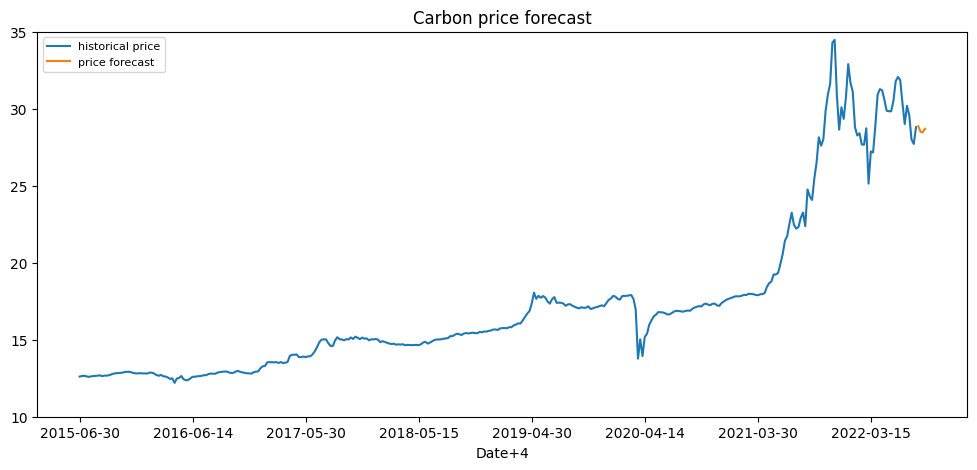

In [163]:
# ext_pred1 = pred1.append({'price prediction': pred1['price prediction'].values[0], 'date': '2022-01'}, ignore_index = True)
# ext_pred1 = ext_pred1.rename({0:82, 1:83}, axis=0)
# ext_df = df.append({'Target_Price+1': df['Target_Price+1'][-1:].values[0], 'Date+1': '2022-01'}, ignore_index = True)
    
plot_forecast('Date+4', 'Target_Price+4', pred1, df)

### 3 months forecast

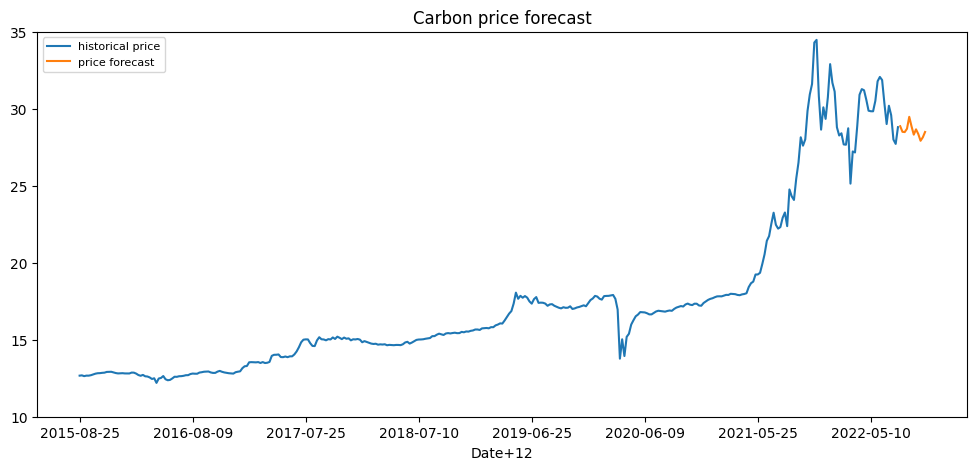

In [164]:
plot_forecast('Date+12', 'Target_Price+12', pred2, df)

### 12 months forecast

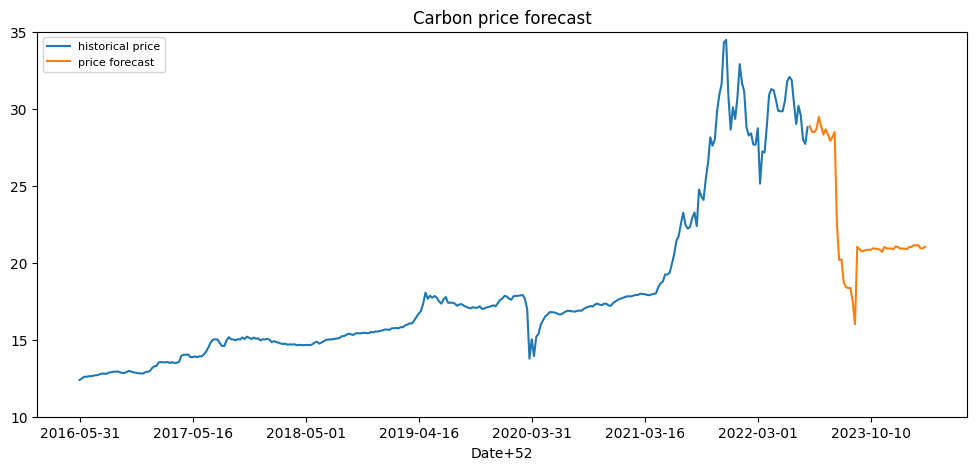

In [165]:
plot_forecast('Date+52', 'Target_Price+52', pred3, df)

## 9. Visualization: feature importance

In [166]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,20))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    

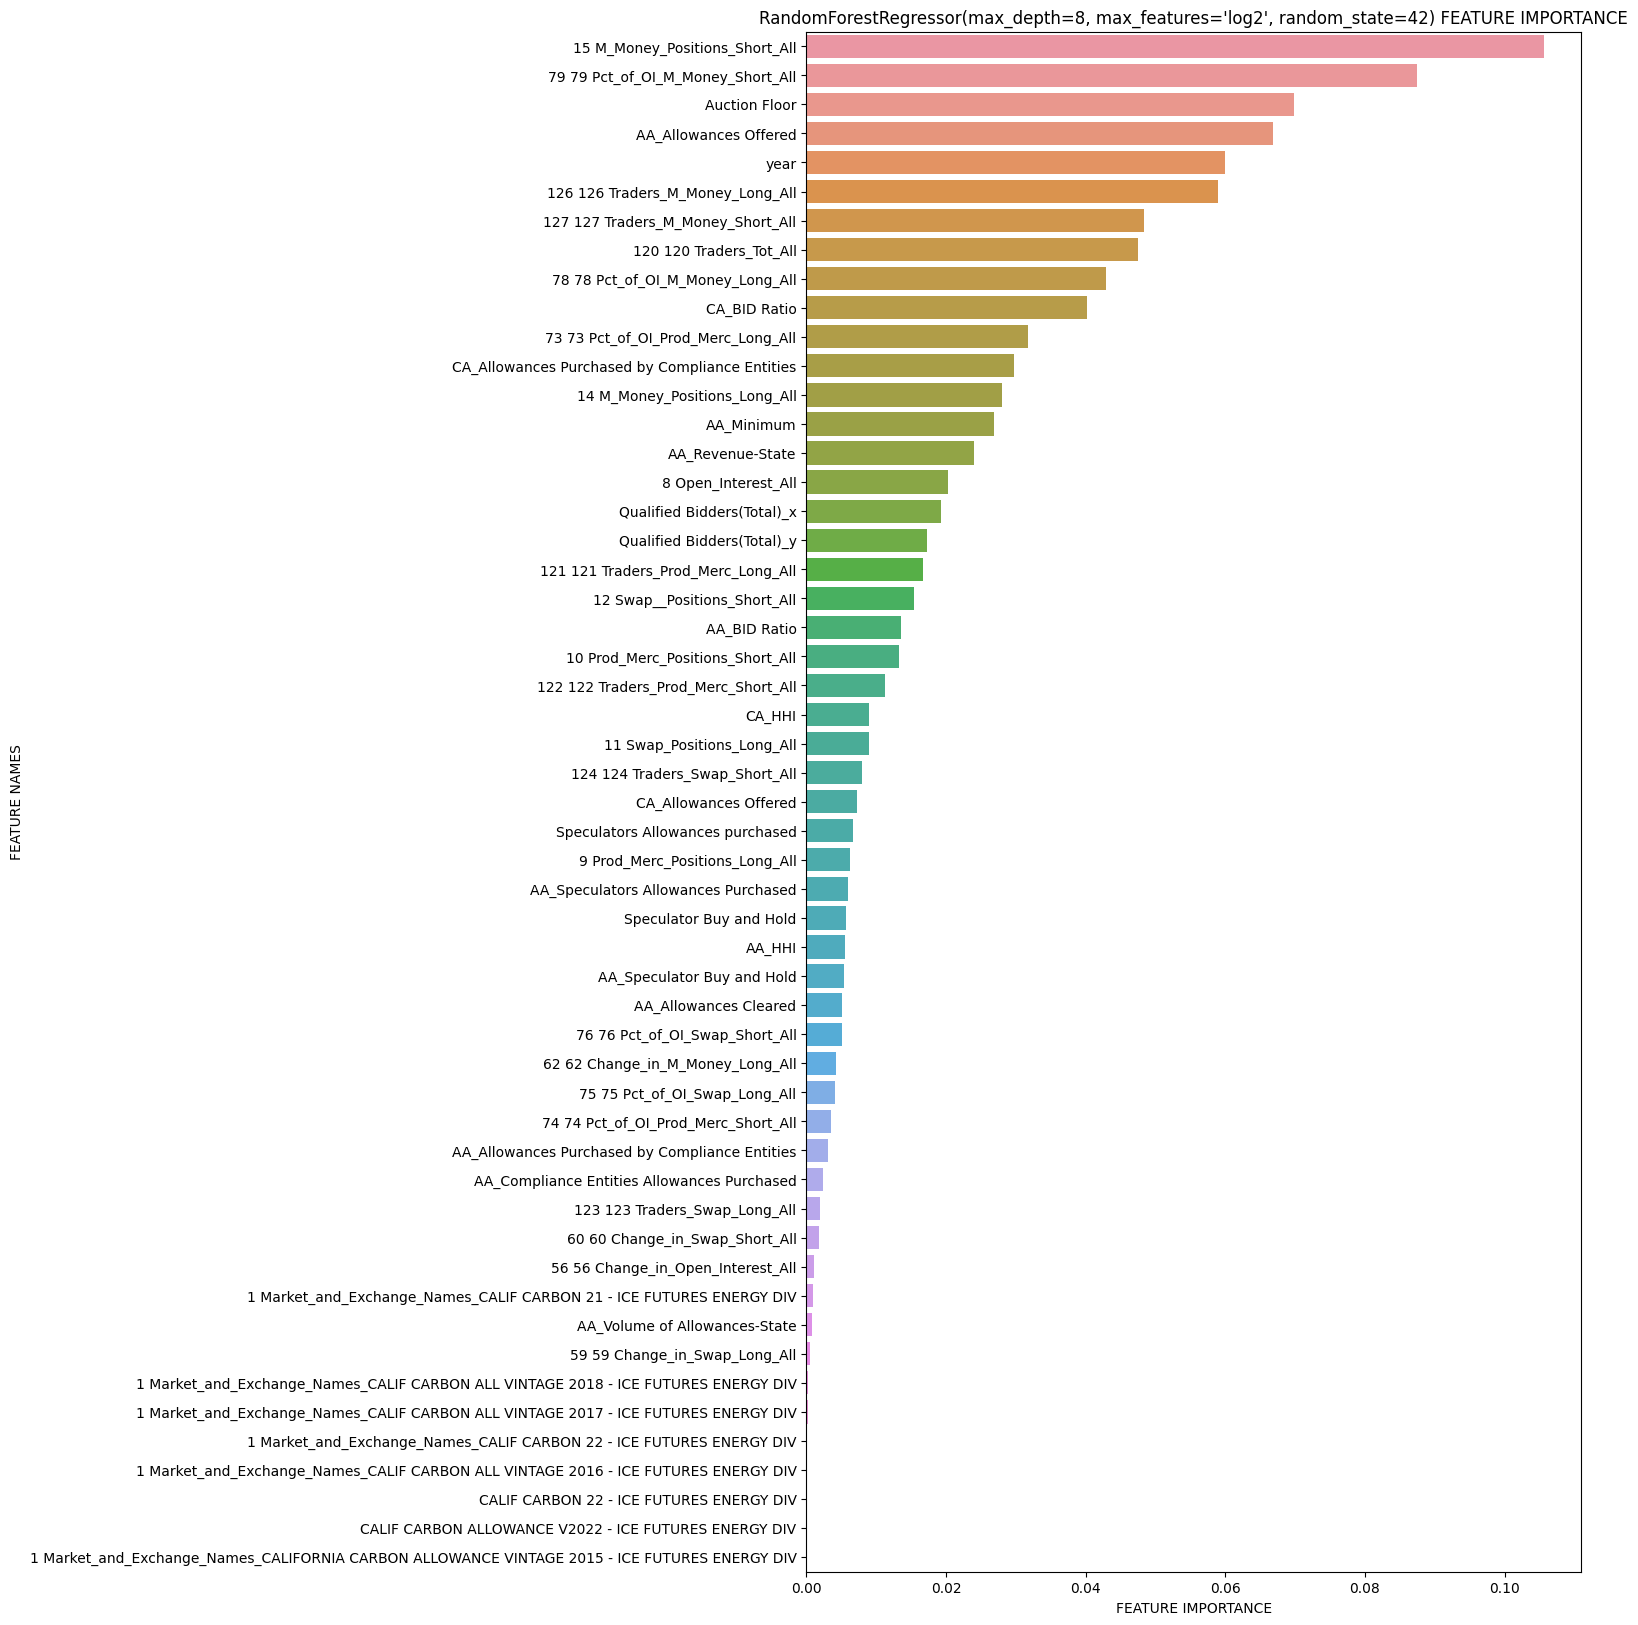

In [167]:
# random forest, 1 month
#plot_feature_importance(models1[0].feature_importances_ ,feature_cols, str(models1[0]))
plot_feature_importance(models1[0].feature_importances_ ,KBest_cols1, str(models1[0]))

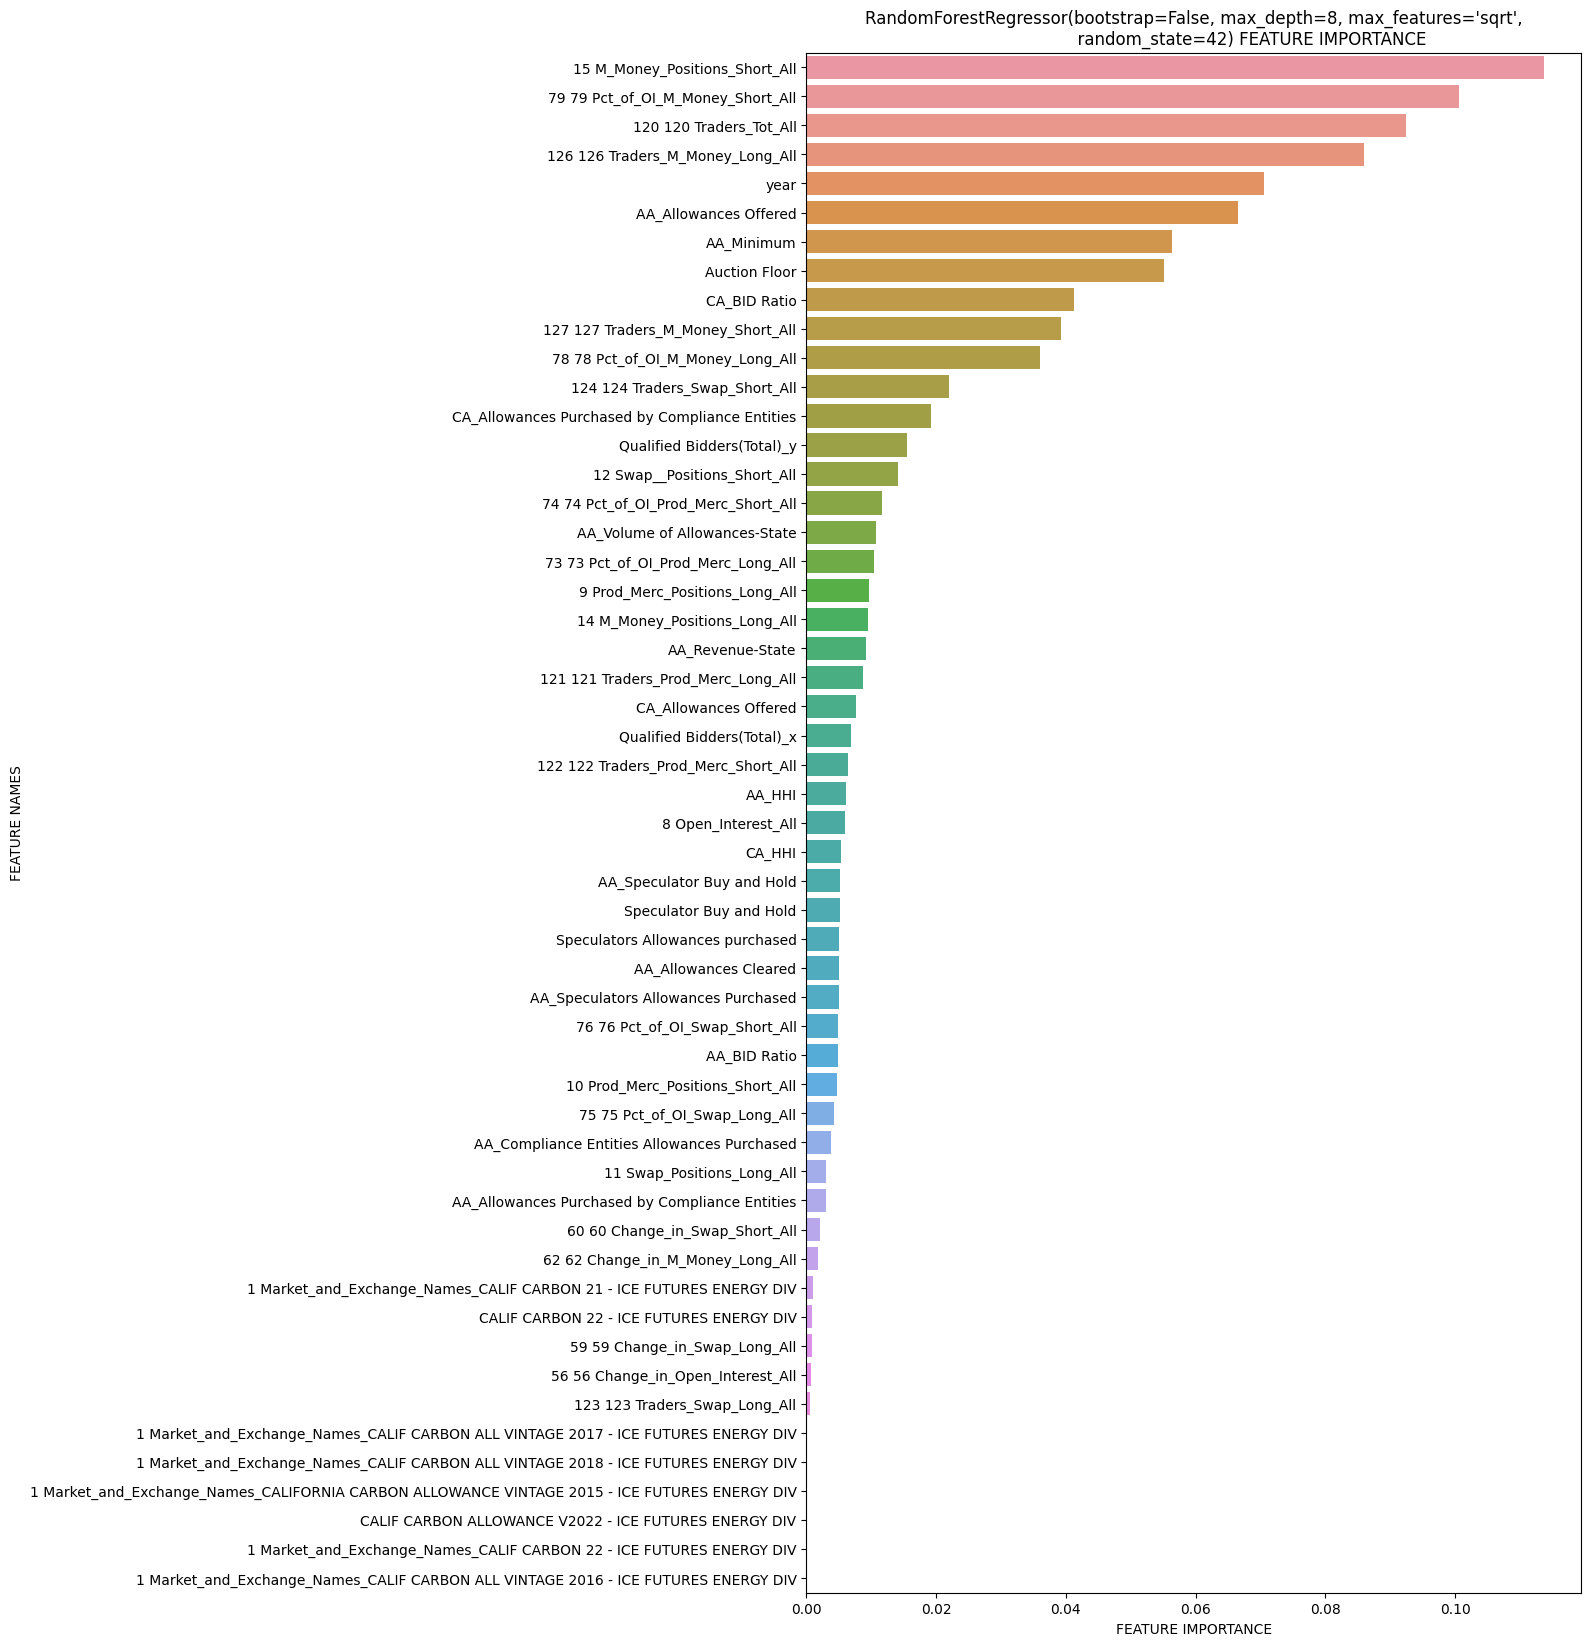

In [168]:
# random forest, 3 months
plot_feature_importance(models2[0].feature_importances_ ,KBest_cols2, str(models2[0]))

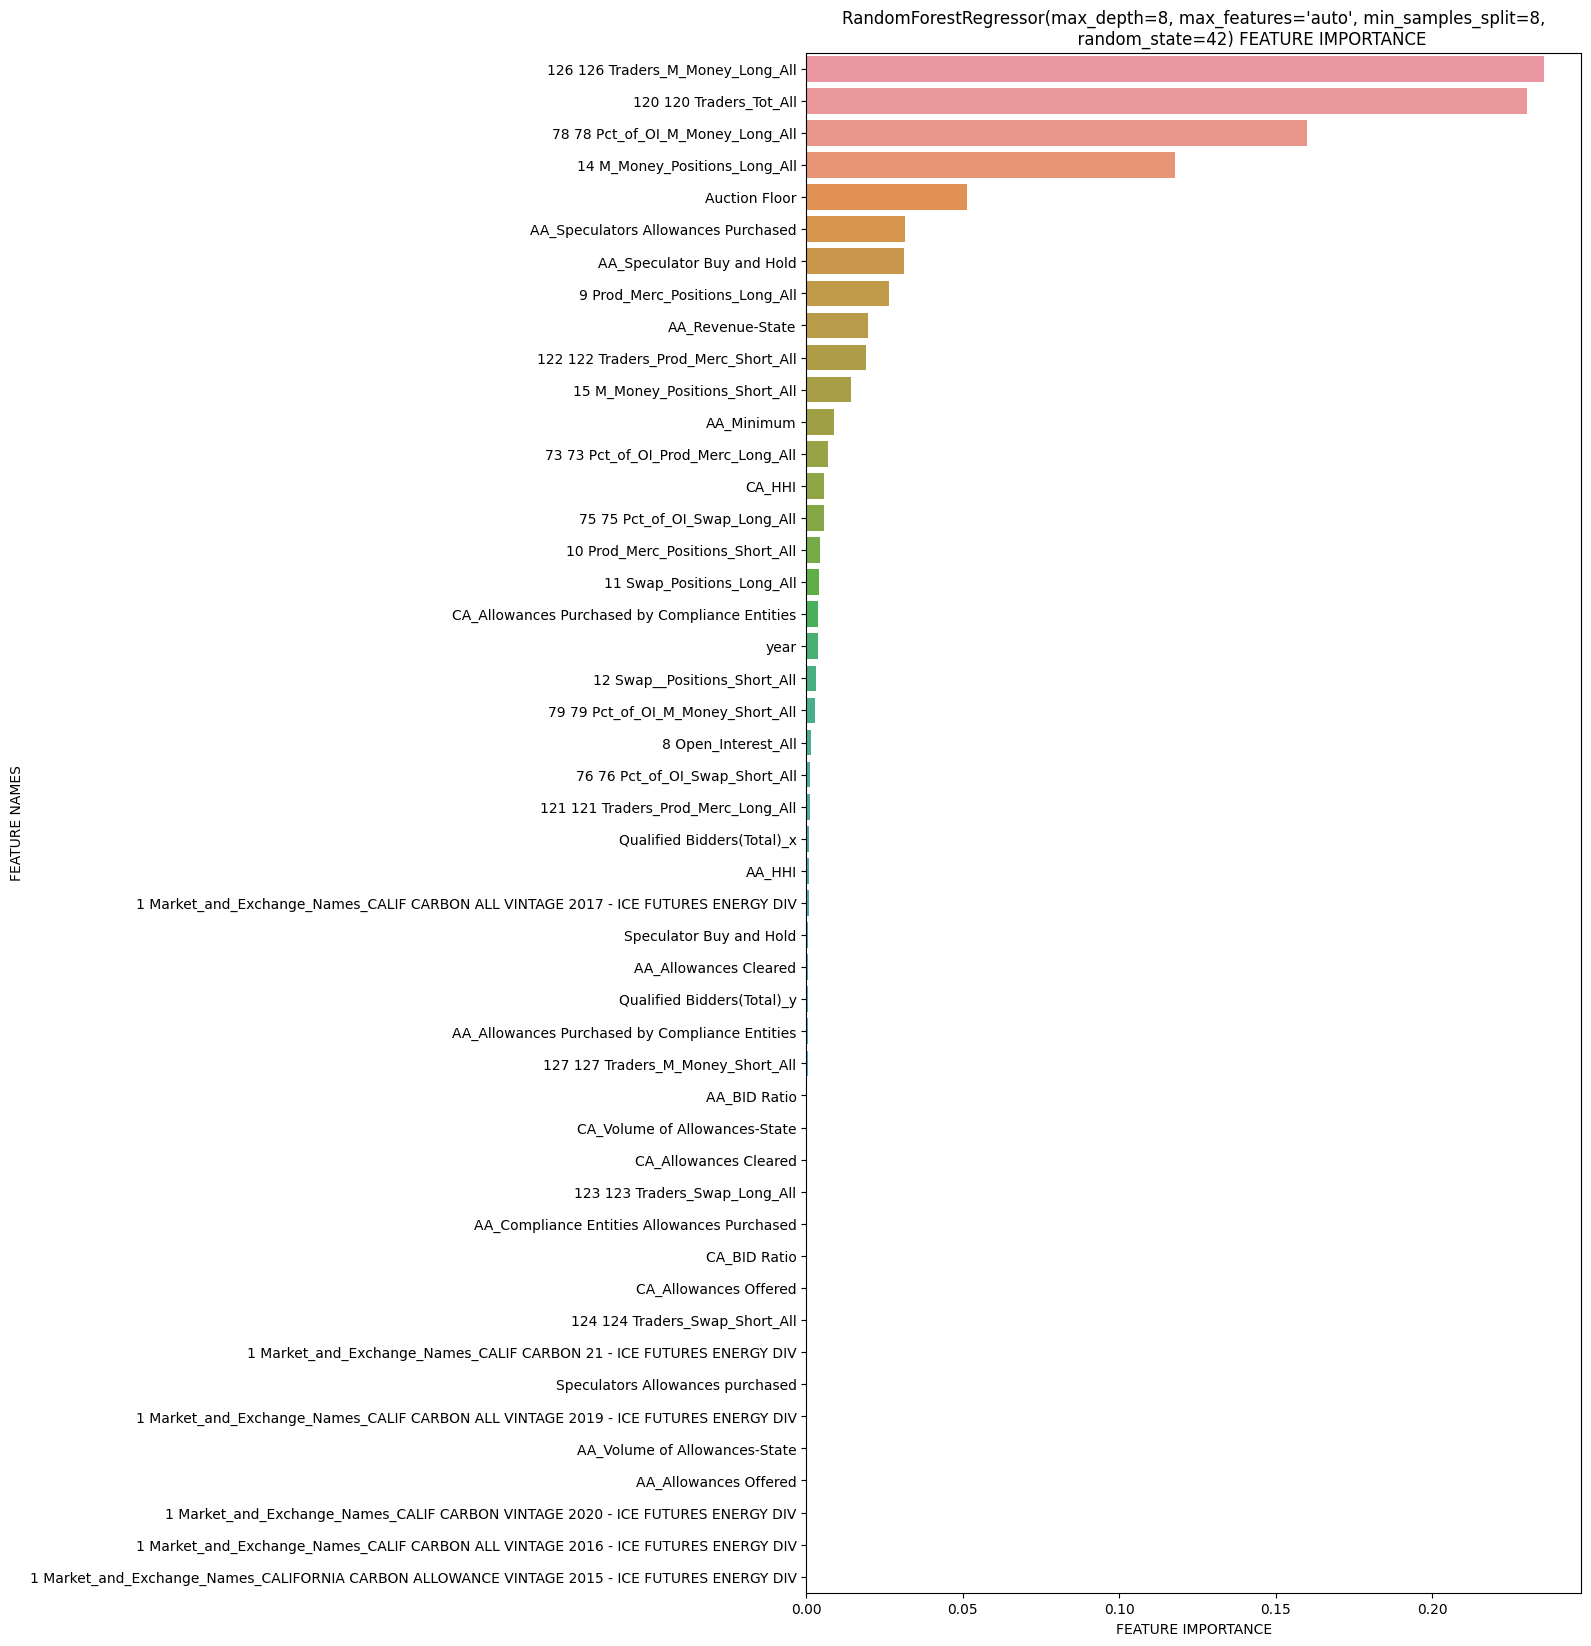

In [169]:
# random forest, 12 months
plot_feature_importance(models3[0].feature_importances_ ,KBest_cols3, str(models3[0]))

In [170]:
# Backup: strongly correlated features with front, soreted in asc order
golden_features = ['Benchmark', 'CA_Median allowance price', 'CA_Clearing Price',
       'AA_Clearing Price', 'CA_Mean', 'AA_Median allowance price',
       'CA_Median', 'AA_Median', 'AA_Mean', 'AA_Percent above Floor',
       '15 M_Money_Positions_Short_All', 'CA_Cleared Above Floor', 'index',
       'CA_Percent Above Floor', '126 126 Traders_M_Money_Long_All',
       'Auction Floor', 'Speculator Buy and Hold',
       'Speculators Allowances purchased', 'CA_Floor Price', 'CA_Minimum',
       'AA_Floor Price', 'CA_Vintage', 'AA_Vintage', 'AA_Cleared Above Floor',
       '11 Swap_Positions_Long_All', '75 75 Pct_of_OI_Swap_Long_All',
       '79 79 Pct_of_OI_M_Money_Short_All', '14 M_Money_Positions_Long_All',
       'AA_Minimum', '120 120 Traders_Tot_All',
       '127 127 Traders_M_Money_Short_All', '78 78 Pct_of_OI_M_Money_Long_All',
       '8 Open_Interest_All',
       'CALIF CARBON CURRENT AUCTION - ICE FUTURES ENERGY DIV',
       'CALIF CARBON VINTAGE 2021 - ICE FUTURES ENERGY DIV', 'CA_BID Ratio',
       '122 122 Traders_Prod_Merc_Short_All',
       '121 121 Traders_Prod_Merc_Long_All', 'AA_Revenue-State',
       '124 124 Traders_Swap_Short_All', 'AA_Allowances Offered',
       '76 76 Pct_of_OI_Swap_Short_All',
       'CA_Allowances Purchased by Compliance Entities']

# Notes: important features according to Anant
# CFTC data: open interest
# '8 Open_Interest_All', '9 Prod_Merc_Positions_Long_All', '10 Prod_Merc_Positions_Short_All',
       #'11 Swap_Positions_Long_All', '12 Swap__Positions_Short_All',
       #'14 M_Money_Positions_Long_All', '15 M_Money_Positions_Short_All', 
       # '121 121 Traders_Prod_Merc_Long_All', '122 122 Traders_Prod_Merc_Short_All', 
       #'123 123 Traders_Swap_Long_All', '124 124 Traders_Swap_Short_All', 
       #'126 126 Traders_M_Money_Long_All', '127 127 Traders_M_Money_Short_All',
        # important for regulations and compliance
        # recheck- importance, more features!!!


In [171]:
type(pred2)

pandas.core.frame.DataFrame

In [172]:
pred2.to_csv('3month_results.csv', index=False)

In [173]:
df.to_csv('fulldf.csv',index=False)

In [174]:
pred1.to_csv('1month_results.csv',index=False)

In [175]:
pred3.to_csv('1year_results.csv',index=False)